<a href="https://colab.research.google.com/github/mahshadmoradi/Machine-Learning/blob/main/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Mahshad Moradi

**Student ID**: 400109373





## Importing Libraries

First we import libraries that we need for this assignment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import any other libraries needed below
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Reading Data and Preprocessing

In this section, we want to read data from a CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the features of the data (`X1`, `X2`, `X3`) and the class (`Y`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [3]:
X, Y = None, None

### START CODE HERE ###

#Read the CSV file into a DataFrame
df = pd.read_csv('data_logistic.csv')

# print(df.head)

X = df.iloc[:, :-1].values  # Extract all rows, and all columns except the last one as features
Y = df.iloc[:, -1].values   # Extract all rows for the last column as the target variable
### END CODE HERE ###

print(X.shape)
print(Y.shape)

(10000, 3)
(10000,)


Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

**Question**: Briefly explain why we need to normalize our data before starting the training.

**Answer**:

**Scale Uniformity**: Different features might be measured on vastly different scales (e.g., age in years and income in thousands of dollars). Without normalization, features on larger scales dominate those on smaller scales, potentially biasing the model.

**Faster Convergence**: When using gradient descent-based optimization methods, features with similar scales tend to help the algorithm converge faster. Without normalization, the optimization path can become skewed, leading to slower convergence.

**Improved Accuracy**: Algorithms that rely on distance calculations (like K-nearest neighbors and Support Vector Machines) or assume normality of the features (like Logistic Regression) can perform better when the data is normalized, leading to improved accuracy.

**Prevent Distortion**: Features with larger scales can distort cost functions, making it harder to find the global minimum. Normalization helps in making the cost function more spherical, easing the optimization process.

**Numerical Stability**: Some algorithms can suffer from numerical instability due to very large or very small values. Normalization helps in mitigating these issues by ensuring values lie within a similar range.

**Model Evaluation**: Normalizing both features and target variables (in regression tasks) allows for a more straightforward comparison between different models and their performance metrics, as the scale of the outputs is consistent.

In [5]:
### START CODE HERE ###

# Normalize X
X_mean = np.mean(X, axis=0)  # Calculate the mean of X for each feature
X_std = np.std(X, axis=0)    # Calculate the standard deviation of X for each feature
X_norm = (X - X_mean) / X_std  # Apply the normalization formula

# Now X_norm contains the normalized features
X, Y = X_norm, Y

### END CODE HERE ###

Finally, we should add a column of $1$s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [6]:
### START CODE HERE ###

# Create a column of 1s, with the same number of rows as X
ones_column = np.ones((X.shape[0], 1))

# Add this column of 1s to the beginning of X
X_with_bias = np.hstack((ones_column, X))

# Now X_with_bias is the updated feature matrix including the bias term
X = X_with_bias  # Overwrite X with the new matrix including the bias term

### END CODE HERE ###

print(X.shape)

(10000, 4)


## Training Model

### Sigmoid Function
You should begin by implementing the $\sigma(\mathbf{x})$ function. Recall that the logistic regression hypothesis $\mathcal{h}()$ is defined as:
$$
\mathcal{h}_{\theta}(\mathbf{x}) = \mathcal{g}(\theta^\mathbf{T}\mathbf{x})
$$
where $\mathcal{g}()$ is the sigmoid function as:
$$
\mathcal{g}(\mathbf{z}) = \frac{1}{1+exp^{-\mathbf{z}}}
$$
The Sigmoid function has the property that $\mathbf{g}(+\infty)\approx 1$ and $\mathcal{g}(−\infty)\approx0$. Test your function by calling `sigmoid(z)` on different test samples. Be certain that your sigmoid function works with both vectors and matrices - for either a vector or a matrix, your function should perform the sigmoid function on every element.

In [7]:
def sigmoid(Z):
    '''
    Applies the sigmoid function on every element of Z
    Arguments:
        Z can be a (n,) vector or (n , m) matrix
    Returns:
        A vector/matrix, same shape with Z, that has the sigmoid function applied elementwise
    '''
    ### START CODE HERE ###

    return 1 / (1 + np.exp(-Z))

    ### END CODE HERE ###

In [ ]:
# Test the sigmoid function
test_scalar = 0
test_vector = np.array([-1, 0, 1, 2])
test_matrix = np.array([[1, 2], [-1, -2]])

print("Sigmoid of scalar 0:", sigmoid(test_scalar))
print("Sigmoid of vector [-1, 0, 1, 2]:", sigmoid(test_vector))
print("Sigmoid of matrix [[1, 2], [-1, -2]]:", sigmoid(test_matrix))

Sigmoid of scalar 0: 0.5
Sigmoid of vector [-1, 0, 1, 2]: [0.26894142 0.5        0.73105858 0.88079708]
Sigmoid of matrix [[1, 2], [-1, -2]]: [[0.73105858 0.88079708]
 [0.26894142 0.11920292]]


### Cost Function
Implement the functions to compute the cost function. Recall the cost function for logistic regression is a scalar value given by:
$$
\mathcal{J}(\theta) = \sum_{i=1}^{n}[-y^{(i)}\log{(\mathcal{h}_\theta(\mathbf{x}^{(i)}))}-(1-y^{(i)})\log{(1-\mathcal{h}_\theta(\mathbf{x}^{(i)}))}] + \frac{\lambda}{2}||\theta||_2^2
$$

In [8]:
def computeCost(theta, X, y, regLambda):
    '''
    Computes the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
    '''

    m, n = X.shape
    loss = None
    ### START CODE HERE ###

    # Logistic regression hypothesis
    h = sigmoid(X.dot(theta))

    # Compute the cost
    loss = (np.sum(-y * np.log(h) -(1 - y) * np.log(1 - h)) / m) + (regLambda / 2) * np.sum(theta[1:]**2)

    ### END CODE HERE ###
    return loss

### Gradient of the Cost Function
Now, we want to calculate the gradient of the cost function. The gradient of the cost function is a d-dimensional vector.\
We must be careful not to regularize the $\theta_0$ parameter (corresponding to the first feature we add to each instance), and so the 0's element is given by:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$

Question: What is the answer to this problem for the $j^{th}$ element (for $j=1...d$)?

Answer:
$$\frac{\partial \mathcal{J}(\theta)}{\partial \theta_j} = \frac{1}{n} \sum_{i=1}^n \left(\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)}\right) x_j^{(i)} + \lambda \theta_j \quad \text{for } j = 1, \ldots, d$$


In [9]:
def computeGradient(theta, X, y, regLambda):
    '''
    Computes the gradient of the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        the gradient, an d-dimensional vector
    '''

    n, d = X.shape
    grad = None
    ### START CODE HERE ###

    # Logistic regression hypothesis
    h = sigmoid(X.dot(theta))

    # Gradient calculation
    error = h - y
    grad = (X.T.dot(error) / n)

    # Regularization for j = 1 to d, note theta_0 is not regularized
    reg = (regLambda / n) * theta
    reg[0] = 0  # No regularization for theta_0

    # Adding regularization to the gradient
    grad += reg

    ### END CODE HERE ###
    return grad

### Training and Prediction
Once you have the cost and gradient functions complete, implemen tthe fit and predict methods.\
Your fit method should train the model via gradient descent, relying on the cost and gradient functions. This function should return two parameters. The first parameter is $\theta$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code.\
Instead of simply running gradient descent for a specific number of iterations, we will use a more sophisticated method: we will stop it after the solution hasconverged. Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations. You can detect this convergence when:
$$
||\theta_{new}-\theta_{old}||_2 <= \epsilon,
$$
for some small $\epsilon$ (e.g, $\epsilon=10E-4$).\
For readability, we’d recommend implementing this convergence test as a dedicated function `hasConverged`.

In [11]:
def fit(X, y, regLambda = 0.01, alpha = 0.1, epsilon = 1e-4, maxNumIters = 100):
    '''
    Trains the model
    Arguments:
        X           is a n-by-d numpy matrix
        y           is an n-dimensional numpy vector
        maxNumIters is the maximum number of gradient descent iterations
        regLambda   is the scalar regularization constant
        epsilon     is the convergence rate
        alpha       is the gradient descent learning rate
    '''

    m, n = X.shape
    theta, loss_history = None, []
    ### START CODE HERE ###

    theta = np.zeros(n)  # Initialize theta

    for iteration in range(maxNumIters):
        theta_old = np.copy(theta)  # Store old theta

        # Compute the gradient and update theta
        gradient = computeGradient(theta, X, y, regLambda)
        theta -= alpha * gradient

        # Compute the cost for the current theta
        cost = computeCost(theta, X, y, regLambda)
        loss_history.append(cost)

        # Check if the convergence criteria are met
        if hasConverged(theta_old, theta, epsilon):
            break

    ### END CODE HERE ###
    return theta, loss_history


def hasConverged(theta_old, theta_new, epsilon):
    '''
    Return if the theta converged or not
    Arguments:
        theta_old   is the theta calculated in prevoius iteration
        theta_new   is the theta calculated in current iteration
        epsilon     is the convergence rate
    '''

    ### START CODE HERE ###

    hasconverged = np.linalg.norm(theta_new - theta_old, 2) <= epsilon

    ### END CODE HERE ###
    return hasconverged

Finally, we want to evaluate our loss for this problem. Complete the cell below to calculate and print the loss of each iteration and the final theta of your model.

In [12]:
theta, loss_history = fit(X, Y) # calculating theta and loss of each iteration

### START CODE HERE ###

# Print the loss at each iteration
for i, loss in enumerate(loss_history):
    print(f"Iteration {i+1}: Loss = {loss:.4f}")

# Print the final theta values
print(f"\nFinal theta: {theta}")

### END CODE HERE ###

Iteration 1: Loss = 0.6767
Iteration 2: Loss = 0.6612
Iteration 3: Loss = 0.6464
Iteration 4: Loss = 0.6323
Iteration 5: Loss = 0.6190
Iteration 6: Loss = 0.6063
Iteration 7: Loss = 0.5942
Iteration 8: Loss = 0.5828
Iteration 9: Loss = 0.5719
Iteration 10: Loss = 0.5615
Iteration 11: Loss = 0.5515
Iteration 12: Loss = 0.5421
Iteration 13: Loss = 0.5331
Iteration 14: Loss = 0.5245
Iteration 15: Loss = 0.5162
Iteration 16: Loss = 0.5084
Iteration 17: Loss = 0.5009
Iteration 18: Loss = 0.4936
Iteration 19: Loss = 0.4867
Iteration 20: Loss = 0.4801
Iteration 21: Loss = 0.4738
Iteration 22: Loss = 0.4676
Iteration 23: Loss = 0.4618
Iteration 24: Loss = 0.4561
Iteration 25: Loss = 0.4507
Iteration 26: Loss = 0.4455
Iteration 27: Loss = 0.4404
Iteration 28: Loss = 0.4356
Iteration 29: Loss = 0.4309
Iteration 30: Loss = 0.4264
Iteration 31: Loss = 0.4220
Iteration 32: Loss = 0.4178
Iteration 33: Loss = 0.4137
Iteration 34: Loss = 0.4098
Iteration 35: Loss = 0.4060
Iteration 36: Loss = 0.4023
I

### Testing Your Implementation
To test your logistic regression implementation, first you should use `train_test_split` function to split dataset into three parts:

- 70% for the training set
- 20% for the validation set
- 10% for the test set

Do this in the cell below.

In [13]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = None, None, None, None, None, None

### START CODE HERE ###

# First, split the data into training (70%) and temp (30%) parts
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Now split the temp part into validation (20% of the original dataset) and test (10% of the original dataset)
# Since 20% is 2/3 of 30%, and 10% is 1/3 of 30%
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=1/3, random_state=42)

### START CODE HERE ###
# As we have already completed the splits above, here you can implement any checks or display info if necessary.
print("Training set size: ", X_train.shape[0])
print("Validation set size: ", X_val.shape[0])
print("Test set size: ", X_test.shape[0])

### END CODE HERE ###

Training set size:  7000
Validation set size:  2000
Test set size:  1000


Then, you should complete `predict` function to find the weight vector and the loss on the test data.

In [14]:
def predict(X, theta):
    '''
    Use the model to predict values for each instance in X
    Arguments:
        theta is d-dimensional numpy vector
        X     is a n-by-d numpy matrix
    Returns:
        an n-dimensional numpy vector of the predictions, the output should be binary (use h_theta > .5)
    '''

    Y = None
    ### START CODE HERE ###

    # Compute the hypothesis using the sigmoid function
    prob = sigmoid(X.dot(theta))

    # Convert probabilities to binary outcomes
    Y = (prob > 0.5).astype(int)

    ### END CODE HERE ###
    return Y

Now, run the `fit` and `predict` function for different values of the learning rate and regularization constant. Plot the `loss_history` of these different values for train and test data both in the same figure.

**Question**: Discuss the effect of the learning rate and regularization constant and find the best values of these parameters.

**Answer**:

Learning Rate (α): A higher learning rate can lead to faster convergence but might overshoot the minimum, leading to divergence in some cases. A lower learning rate ensures more stable convergence but at the cost of slower training.
Regularization Constant (λ): Higher regularization values help prevent overfitting by penalizing large weights, but too high a value can lead to underfitting as the model becomes too biased towards smaller weights. Conversely, a smaller λ might lead to overfitting, especially with complex models.

Learning Rate: 0.001, Regularization: 0.01 - Train Accuracy: 0.9946, Test Accuracy: 0.9940
Learning Rate: 0.001, Regularization: 0.1 - Train Accuracy: 0.9946, Test Accuracy: 0.9940
Learning Rate: 0.001, Regularization: 1 - Train Accuracy: 0.9946, Test Accuracy: 0.9940
Learning Rate: 0.01, Regularization: 0.01 - Train Accuracy: 0.9951, Test Accuracy: 0.9950
Learning Rate: 0.01, Regularization: 0.1 - Train Accuracy: 0.9951, Test Accuracy: 0.9950
Learning Rate: 0.01, Regularization: 1 - Train Accuracy: 0.9951, Test Accuracy: 0.9950
Learning Rate: 0.1, Regularization: 0.01 - Train Accuracy: 0.9967, Test Accuracy: 0.9970
Learning Rate: 0.1, Regularization: 0.1 - Train Accuracy: 0.9967, Test Accuracy: 0.9970
Learning Rate: 0.1, Regularization: 1 - Train Accuracy: 0.9966, Test Accuracy: 0.9970



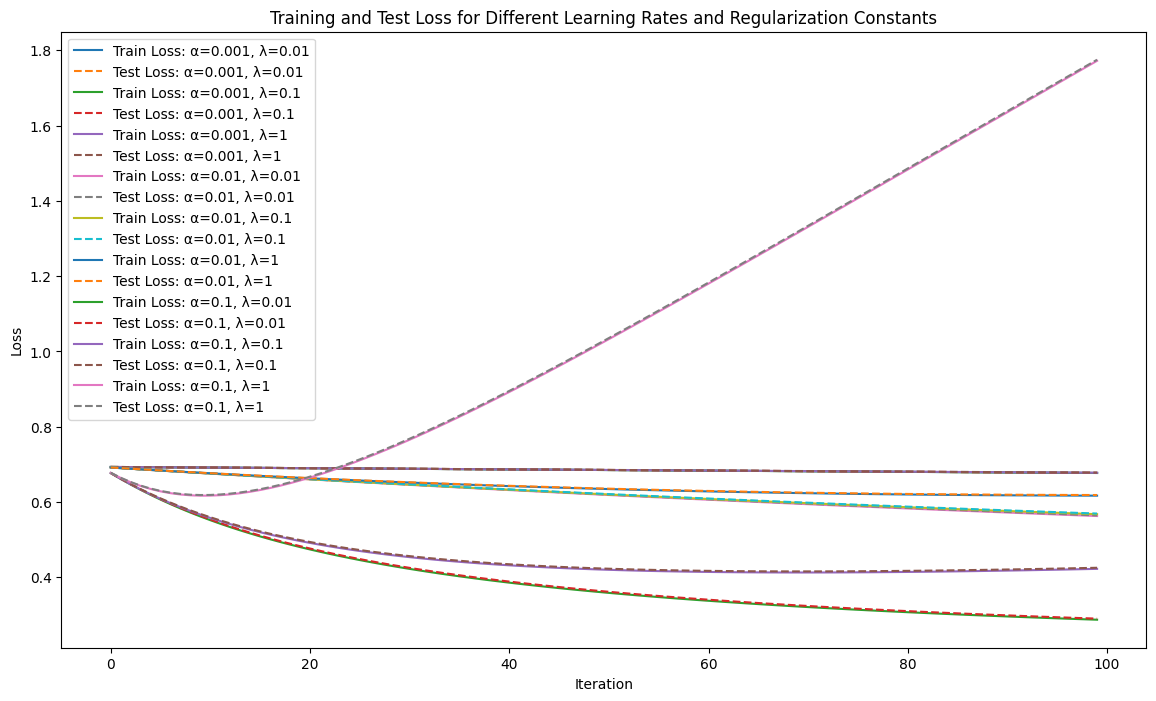

In [23]:
### START CODE HERE ###

# Modify the existing function to also track accuracy
def fit_and_predict(X_train, Y_train, X_test, Y_test, alpha, regLambda, maxNumIters=100):
    m, n = X_train.shape
    theta = np.zeros(n)
    train_loss_history = []
    test_loss_history = []

    for _ in range(maxNumIters):
        # Gradient descent update
        gradient = computeGradient(theta, X_train, Y_train, regLambda)
        theta -= alpha * gradient

        # Compute and store train and test losses
        train_loss = computeCost(theta, X_train, Y_train, regLambda)
        test_loss = computeCost(theta, X_test, Y_test, regLambda)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

    # Predict and calculate accuracy
    train_predictions = predict(X_train, theta)
    test_predictions = predict(X_test, theta)
    train_accuracy = np.mean(train_predictions == Y_train)
    test_accuracy = np.mean(test_predictions == Y_test)

    return theta, train_loss_history, test_loss_history, train_accuracy, test_accuracy

learning_rates = [0.001, 0.01, 0.1]
regularization_constants = [0.01, 0.1, 1]

train_acc = []
test_acc = []

# Simulate training and testing process
plt.figure(figsize=(14, 8))
for alpha in learning_rates:
    for regLambda in regularization_constants:
        theta, train_loss_history, test_loss_history, train_accuracy, test_accuracy = fit_and_predict(
            X_train, Y_train, X_test, Y_test, alpha, regLambda)

        # Print the accuracies for each parameter combination
        print(f"Learning Rate: {alpha}, Regularization: {regLambda} - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Plot loss histories
        plt.plot(train_loss_history, label=f'Train Loss: α={alpha}, λ={regLambda}')
        plt.plot(test_loss_history, linestyle='--', label=f'Test Loss: α={alpha}, λ={regLambda}')

print()
# Add labels, legend, and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Test Loss for Different Learning Rates and Regularization Constants')
plt.legend()
plt.show()

## Naive Bayes

In this part, you will use the `GaussianNB` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**:

In [26]:
### START CODE HERE ###

# Create a Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier on the training data
gnb.fit(X_train, Y_train)

# Predict the labels of the test set
Y_pred = gnb.predict(X_test)

# Calculate the accuracy of the predictions on the test set
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of Gaussian Naive Bayes on the test set:", accuracy)

### END CODE HERE ###

Accuracy of Gaussian Naive Bayes on the test set: 0.929


## LDA (Linear Discriminant Analysis)

In this part, you will use the `LinearDiscriminantAnalysis` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**:

In [25]:
### START CODE HERE ###

# Create an instance of the LinearDiscriminantAnalysis classifier
lda = LinearDiscriminantAnalysis()

# Train the classifier on the training data
lda.fit(X_train, Y_train)

# Predict the labels of the test data
Y_pred = lda.predict(X_test)

# Calculate the accuracy of the predictions on the test set
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of Linear Discriminant Analysis on the test set:", accuracy)

### END CODE HERE ###

Accuracy of Linear Discriminant Analysis on the test set: 0.985


## Conclusion

**Question**: What is the best method for classifying this dataset? What is the best accuracy on the test set?

**Answer**:
The best method is Logistic Regression, because it gives the highest accuracy on test data. Among all the 3 methods tested with their default parameters Logistic Regression gives highest accuracy of 99.7% when gets tuned on parameters.